## 1. Importation Libraries

In [3]:
import pandas as pd
import seaborn as snb
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline
from pandas.plotting import parallel_coordinates
import plotly.graph_objects as go
import plotly.express as px
from tpot import TPOTRegressor
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_regression
import copulas
from copulas.multivariate import GaussianMultivariate



C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


## 2. Data Cleaning

In [4]:
# Read the Stamping data from the Excel file
df = pd.read_excel('Raw_Data_v0.xlsx')

# Cleaning
df = df.drop(columns=['Ref#','Heat treatment'])
df['Raw Material'] = df['Raw Material'].str.title()

# Substitute every NaN with 'NA'
df = df.fillna('0')

In [5]:
all_parts = set()
# Assuming df is already defined and contains the column "Other assembled RM/Rivet/part"
df["Other assembled RM/Rivet/part"].dropna().str.split(r" \+ ").apply(all_parts.update)

# Creating new columns for each extracted part
for part in all_parts:
    df[part] = df["Other assembled RM/Rivet/part"].apply(lambda x: 1 if part in x and pd.notna(x) else 0)

df = df.drop(columns=['0', 'Other assembled RM/Rivet/part'])
df.drop(columns=["Other RM/Rivet/part cost (€/Part)"], inplace=True)

In [6]:
df

,Production,Annual target quantity,Raw Material,Raw Material Designation,Surface Treatment,Raw Material Cost (€/kg),Thickness (mm),Part Net Weight (g),Gross Weight (g),Final Raw Material cost (€/Part),Surface Treatment cost (€/Part),Heat Treatment cost (€/Part),Total cost with amortization (€/part),Steel part,Silver foil
0,A,1500000.0,Copper,Cu-ETP-R240,0,9.400663,1.5,3.000,5.773680,0.035346,0.000000,0.0,0.051500,0,1
1,A,1000000.0,Copper,Cu-ETP-R240,Sn5,9.804307,1.6,3.200,5.363107,0.038595,0.004970,0.0,0.058863,0,1
2,A,1500000.0,Copper,Cu-ETP-R240,Sn5,9.804307,1.3,5.107,9.425666,0.064738,0.006737,0.0,0.089343,0,1
3,A,1500000.0,Copper,Cu-ETP-R240,Sn5,9.401325,1.5,3.731,6.602310,0.042341,0.006184,0.0,0.057637,0,0
4,A,1500000.0,Steel,DC03,Sn5,1.236886,1.5,3.300,5.816850,0.006726,0.006184,0.0,0.018332,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,E,44538.0,Copper,Cu-ETP-R240,0,9.354414,6.0,0.056,0.123000,0.799868,0.000000,0.0,1.538638,0,0
155,E,38260.0,Steel,SUS304 1/2H,0,3.689065,2.5,0.034,0.056000,0.220553,0.000000,0.0,0.353694,0,0
156,E,13478.0,Steel,SPCC-2B,ZnCr3+,1.185771,2.0,0.064,0.154000,0.191041,0.092227,0.0,0.648388,0,0
157,E,38260.0,Steel,SPCC-2B,ZnCr3+,1.185771,2.0,0.010,0.020000,0.025296,0.013175,0.0,0.097968,0,0


In [7]:

# Columns to encode
columns_to_encode = ['Production', 'Raw Material', 'Raw Material Designation', 'Surface Treatment']
target_column = 'Total cost with amortization (€/part)'

# Mean Encoding
def mean_encode(df, columns, target):
    for col in columns:
        mean_map = df.groupby(col)[target].mean()
        df[col + '_encoded'] = df[col].map(mean_map)
    return df

df = mean_encode(df, columns_to_encode, target_column)

# Drop original categorical columns
df.drop(columns=columns_to_encode, inplace=True)

In [8]:
df

,Annual target quantity,Raw Material Cost (€/kg),Thickness (mm),Part Net Weight (g),Gross Weight (g),Final Raw Material cost (€/Part),Surface Treatment cost (€/Part),Heat Treatment cost (€/Part),Total cost with amortization (€/part),Steel part,Silver foil,Production_encoded,Raw Material_encoded,Raw Material Designation_encoded,Surface Treatment_encoded
0,1500000.0,9.400663,1.5,3.000,5.773680,0.035346,0.000000,0.0,0.051500,0,1,0.030084,0.595537,0.368182,0.195312
1,1000000.0,9.804307,1.6,3.200,5.363107,0.038595,0.004970,0.0,0.058863,0,1,0.030084,0.595537,0.368182,0.290730
2,1500000.0,9.804307,1.3,5.107,9.425666,0.064738,0.006737,0.0,0.089343,0,1,0.030084,0.595537,0.368182,0.290730
3,1500000.0,9.401325,1.5,3.731,6.602310,0.042341,0.006184,0.0,0.057637,0,0,0.030084,0.595537,0.368182,0.290730
4,1500000.0,1.236886,1.5,3.300,5.816850,0.006726,0.006184,0.0,0.018332,0,0,0.030084,0.231952,0.013658,0.290730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,44538.0,9.354414,6.0,0.056,0.123000,0.799868,0.000000,0.0,1.538638,0,0,0.630268,0.595537,0.368182,0.195312
155,38260.0,3.689065,2.5,0.034,0.056000,0.220553,0.000000,0.0,0.353694,0,0,0.630268,0.231952,0.353694,0.195312
156,13478.0,1.185771,2.0,0.064,0.154000,0.191041,0.092227,0.0,0.648388,0,0,0.630268,0.231952,1.409974,1.227207
157,38260.0,1.185771,2.0,0.010,0.020000,0.025296,0.013175,0.0,0.097968,0,0,0.630268,0.231952,1.409974,1.227207


In [9]:
# Calculate Weight Loss
df["Weight Loss"] = (df["Gross Weight (g)"] - df["Part Net Weight (g)"]) / df["Gross Weight (g)"]

In [10]:
# Drop the "Gross Weight (g)" column
df.drop(columns=["Gross Weight (g)"], inplace=True)

In [11]:
df

,Annual target quantity,Raw Material Cost (€/kg),Thickness (mm),Part Net Weight (g),Final Raw Material cost (€/Part),Surface Treatment cost (€/Part),Heat Treatment cost (€/Part),Total cost with amortization (€/part),Steel part,Silver foil,Production_encoded,Raw Material_encoded,Raw Material Designation_encoded,Surface Treatment_encoded,Weight Loss
0,1500000.0,9.400663,1.5,3.000,0.035346,0.000000,0.0,0.051500,0,1,0.030084,0.595537,0.368182,0.195312,0.480401
1,1000000.0,9.804307,1.6,3.200,0.038595,0.004970,0.0,0.058863,0,1,0.030084,0.595537,0.368182,0.290730,0.403331
2,1500000.0,9.804307,1.3,5.107,0.064738,0.006737,0.0,0.089343,0,1,0.030084,0.595537,0.368182,0.290730,0.458182
3,1500000.0,9.401325,1.5,3.731,0.042341,0.006184,0.0,0.057637,0,0,0.030084,0.595537,0.368182,0.290730,0.434895
4,1500000.0,1.236886,1.5,3.300,0.006726,0.006184,0.0,0.018332,0,0,0.030084,0.231952,0.013658,0.290730,0.432683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,44538.0,9.354414,6.0,0.056,0.799868,0.000000,0.0,1.538638,0,0,0.630268,0.595537,0.368182,0.195312,0.544715
155,38260.0,3.689065,2.5,0.034,0.220553,0.000000,0.0,0.353694,0,0,0.630268,0.231952,0.353694,0.195312,0.392857
156,13478.0,1.185771,2.0,0.064,0.191041,0.092227,0.0,0.648388,0,0,0.630268,0.231952,1.409974,1.227207,0.584416
157,38260.0,1.185771,2.0,0.010,0.025296,0.013175,0.0,0.097968,0,0,0.630268,0.231952,1.409974,1.227207,0.500000


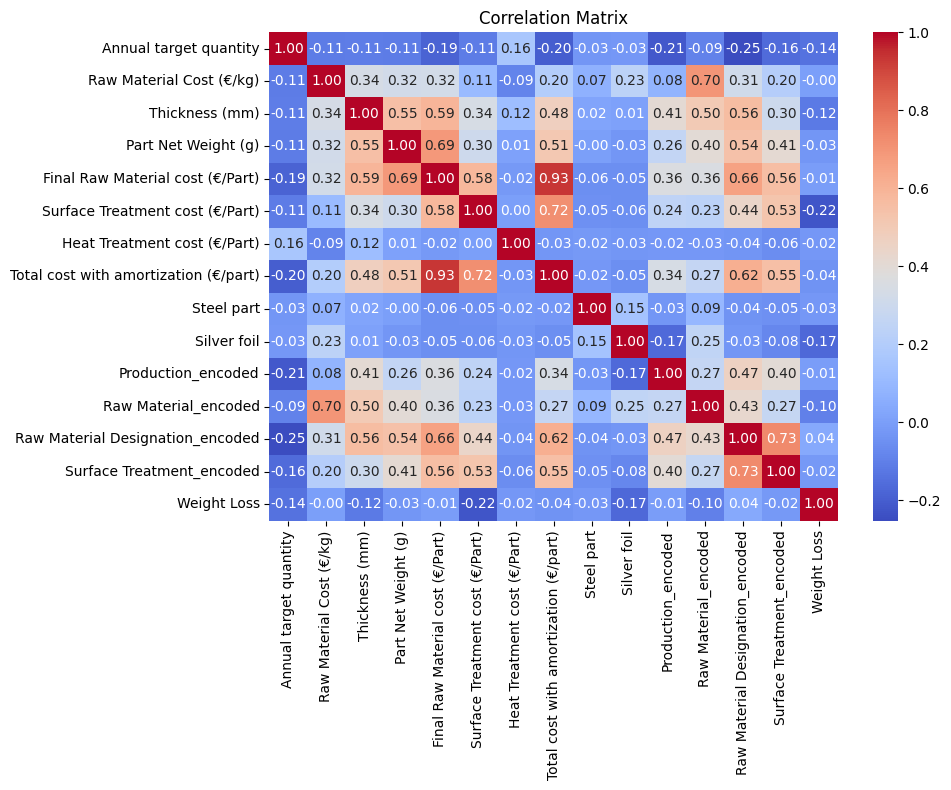

In [12]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

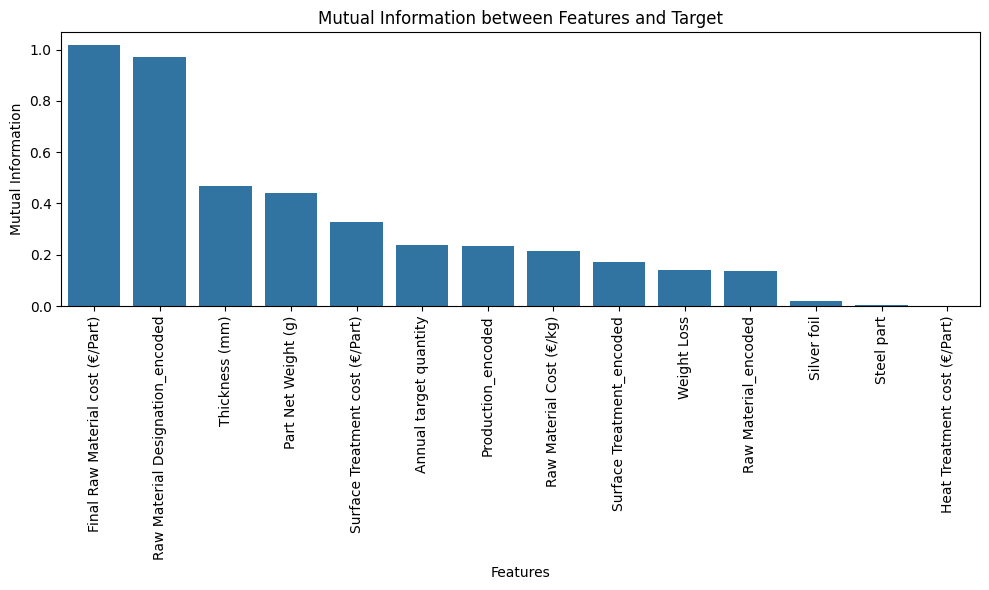

Final Raw Material cost (€/Part)    1.016378
Raw Material Designation_encoded    0.971122
Thickness (mm)                      0.466803
Part Net Weight (g)                 0.442045
Surface Treatment cost (€/Part)     0.326728
Annual target quantity              0.239785
Production_encoded                  0.233462
Raw Material Cost (€/kg)            0.215219
Surface Treatment_encoded           0.171183
Weight Loss                         0.140439
Raw Material_encoded                0.138149
Silver foil                         0.018616
Steel part                          0.002614
Heat Treatment cost (€/Part)        0.000000
dtype: float64


In [13]:
target_column = 'Total cost with amortization (€/part)'
features = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)',
    'Part Net Weight (g)', 'Final Raw Material cost (€/Part)',
    'Surface Treatment cost (€/Part)', 'Heat Treatment cost (€/Part)', 'Steel part', 'Silver foil',
    'Production_encoded', 'Raw Material_encoded', 'Raw Material Designation_encoded',
    'Surface Treatment_encoded','Weight Loss'
]

# Check if the features and target columns exist
missing_columns = []
for column in features + [target_column]:
  if column not in df.columns:
    missing_columns.append(column)

if missing_columns:
  raise ValueError(f"The following columns are missing in the DataFrame: {', '.join(missing_columns)}")

X = df[features]
y = df[target_column]

mutual_info = mutual_info_regression(X, y)
mutual_info_series = pd.Series(mutual_info, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=mutual_info_series.index, y=mutual_info_series.values)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Mutual Information")
plt.title("Mutual Information between Features and Target")
plt.tight_layout()
plt.show()

print(mutual_info_series)


Kendall's Tau Values:
Annual target quantity: -0.397
Raw Material Cost (€/kg): 0.220
Thickness (mm): 0.405
Part Net Weight (g): 0.290
Final Raw Material cost (€/Part): 0.667
Surface Treatment cost (€/Part): 0.243
Heat Treatment cost (€/Part): -0.116
Steel part: 0.085
Silver foil: 0.059
Production_encoded: 0.290
Weight Loss: -0.067
Raw Material_encoded: 0.231
Raw Material Designation_encoded: 0.685
Surface Treatment_encoded: 0.288
Number of marginals: 15
Shape of copula_data: (159, 15)
Copula dimension: 15
Gaussian Copula fitted


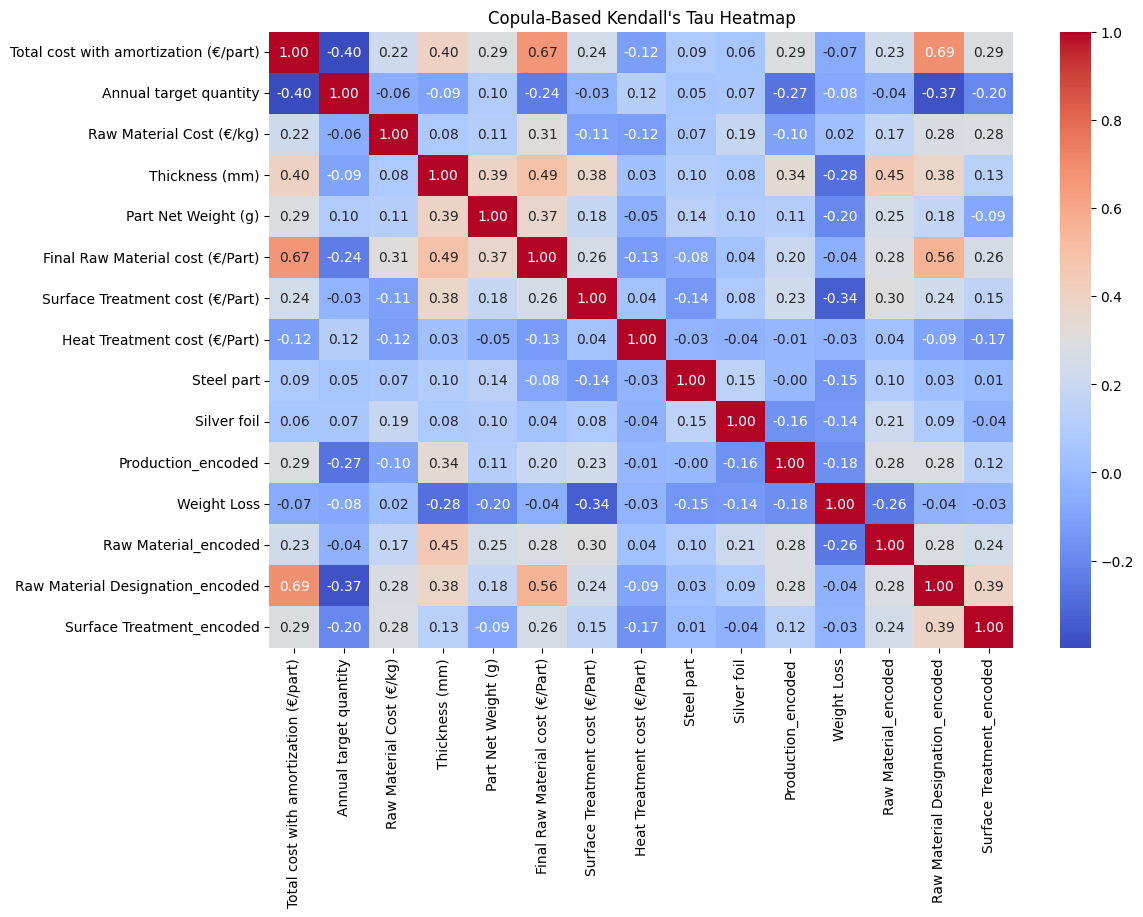

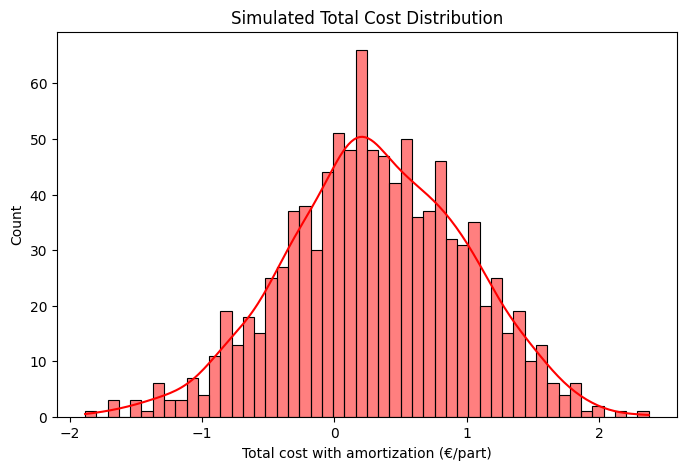

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.distributions.copula.api import ClaytonCopula, GumbelCopula, GaussianCopula, CopulaDistribution
from scipy.stats import kendalltau, norm

# Define target and features
target_column = 'Total cost with amortization (€/part)'
features = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)',
    'Part Net Weight (g)', 'Final Raw Material cost (€/Part)',
    'Surface Treatment cost (€/Part)', 'Heat Treatment cost (€/Part)', 'Steel part', 'Silver foil',
    'Production_encoded','Weight Loss' ,'Raw Material_encoded', 'Raw Material Designation_encoded',
    'Surface Treatment_encoded'
]

# Compute Kendall's Tau for each feature vs the target
kendall_tau_values = {feature: kendalltau(df[feature], df[target_column])[0] for feature in features}

# Print correlation values to determine dependency
print("Kendall's Tau Values:")
for feature, tau in kendall_tau_values.items():
    print(f"{feature}: {tau:.3f}")

# Convert features & target to uniform distribution (needed for copulas)
def rank_transform(series):
    return (series.rank(method='average') - 1) / (len(series) - 1)

# Ensure we are using the correct number of features + target
copula_data = df[[target_column] + features].dropna()
copula_data = copula_data.apply(rank_transform)

# Calculate the dimension for the copula (number of variables)
dim = copula_data.shape[1]

# Estimate copula parameter from Kendall's Tau
tau_mean = np.mean(list(kendall_tau_values.values()))
if tau_mean > 0.3:
    copula_type = "Gumbel"
    theta = 1 / (1 - tau_mean)
    copula = GumbelCopula(theta=theta, dim=dim)
elif tau_mean < -0.3:
    copula_type = "Clayton"
    theta = 2 * tau_mean / (1 - tau_mean)
    copula = ClaytonCopula(theta=theta, dim=dim)
else:
    copula_type = "Gaussian"
    # Create a correlation matrix for the Gaussian copula
    corr_matrix = copula_data.corr().values
    copula = GaussianCopula(corr=corr_matrix)
    theta = None  # Gaussian copula does not use theta

# Fit normal distributions to each marginal variable (target + features)
marginals = [norm(loc=df[col].mean(), scale=df[col].std()) for col in [target_column] + features]

# Debug prints
print(f"Number of marginals: {len(marginals)}")
print(f"Shape of copula_data: {copula_data.shape}")
print(f"Copula dimension: {dim}")

# Ensure the number of marginals matches the number of columns in copula_data
if len(marginals) != copula_data.shape[1]:
    raise ValueError("Number of marginals does not match the number of columns in copula_data")

# Create the copula distribution with proper marginals
copula_dist = CopulaDistribution(copula=copula, marginals=marginals)

if theta is not None:
    print(f"{copula_type} Copula fitted with parameter theta={theta:.3f}")
else:
    print(f"{copula_type} Copula fitted")

# Plot heatmap of Kendall's Tau dependencies
plt.figure(figsize=(12, 8))
sns.heatmap(copula_data.corr(method=lambda x, y: kendalltau(x, y)[0]), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Copula-Based Kendall's Tau Heatmap")
plt.show()

# Generate synthetic data from the fitted copula
simulated_data = copula_dist.rvs(1000)

# Convert to DataFrame for analysis
simulated_df = pd.DataFrame(simulated_data, columns=[target_column] + features)

# Plot simulated target cost distribution
plt.figure(figsize=(8, 5))
sns.histplot(simulated_df[target_column], bins=50, kde=True, color='red')
plt.title("Simulated Total Cost Distribution")
plt.xlabel("Total cost with amortization (€/part)")
plt.show()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Annual target quantity                 159 non-null    float64
 1   Raw Material Cost (€/kg)               159 non-null    float64
 2   Thickness (mm)                         159 non-null    float64
 3   Part Net Weight (g)                    159 non-null    float64
 4   Final Raw Material cost (€/Part)       159 non-null    float64
 5   Surface Treatment cost (€/Part)        159 non-null    float64
 6   Heat Treatment cost (€/Part)           159 non-null    float64
 7   Total cost with amortization (€/part)  159 non-null    float64
 8   Steel part                             159 non-null    int64  
 9   Silver foil                            159 non-null    int64  
 10  Production_encoded                     159 non-null    float64
 11  Raw Ma